# All imports #

In [1]:
from __future__ import print_function

import sys, os
import tensorflow as tf
import tensorflow.keras
import pandas as pd
import numpy as np
import sklearn
import keras
import csv

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout

from keras_uncertainty.models import MCDropoutClassifier, MCDropoutRegressor
from keras_uncertainty.utils import numpy_regression_nll


/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/d

In [2]:
def load_joint_space_csv_chunks(file_path):
    data_frame = pd.read_csv(file_path, skiprows=1, header=None)
    del data_frame[18]
    return data_frame

def load_task_space_csv_chunks(file_path):
    return pd.read_csv(file_path, skiprows=1, header=None)


In [3]:
##please select the appropriate folder, willl use os.path.join() for completed script
TRAIN_FOLDER = '/home/dfki.uni-bremen.de/bmanickavasakan/newdataset_rh5_leg/leg_5steps/'
TEST_FOLDER = '/home/dfki.uni-bremen.de/bmanickavasakan/newdataset_rh5_leg/leg_5steps/test_4steps'

X_TRAIN_FILE = os.path.join(TRAIN_FOLDER, 'leg_forwardkinematics_x.csv')
Q_TRAIN_FILE = os.path.join(TRAIN_FOLDER, 'leg_sysstate_q.csv')
x_train = load_task_space_csv_chunks(X_TRAIN_FILE)
q_train = load_joint_space_csv_chunks(Q_TRAIN_FILE)

X_TEST_FILE = os.path.join(TEST_FOLDER, 'leg_forwardkinematics_x.csv')
Q_TEST_FILE = os.path.join(TEST_FOLDER, 'leg_sysstate_q.csv')
x_test = load_task_space_csv_chunks(X_TEST_FILE)
q_test = load_joint_space_csv_chunks(Q_TEST_FILE)

# Building the model with MC Droput #

In [5]:
"""
+/- based data splitting
We consider the Q features and use the feature with the highest SD for dividing the dataset. 
We consider all the positive values as IOD and all the negative values as OOD
"""

stats_q_train = pd.DataFrame()
stats_q_train["Mean"] = q_train.mean()
stats_q_train["Var"] = q_train.var()
stats_q_train["STD"] = q_train.std()
stats_q_train["OneSigmaMax"] = stats_q_train["Mean"] + stats_q_train["STD"]
stats_q_train["OneSigmaMin"] = stats_q_train["Mean"] - stats_q_train["STD"]
stats_q_train.T

max_std = stats_q_train["STD"].max()
colomn_max_std = stats_q_train["STD"].idxmax()

value = 0

InDistribution_Q_Train =  q_train[q_train[colomn_max_std] > value]
OutDistribution_Q_Train = q_train[q_train[colomn_max_std] < value]
InDistribution_X_Train =  x_train[q_train[colomn_max_std] > value]
OutDistribution_X_Train = x_train[q_train[colomn_max_std] < value]

InDistribution_Q_Test =  q_test[q_test[colomn_max_std] > value]
OutDistribution_Q_Test = q_test[q_test[colomn_max_std] < value]
InDistribution_X_Test =  x_test[q_test[colomn_max_std] > value]
OutDistribution_X_Test = x_test[q_test[colomn_max_std] < value]

x_train_1 = InDistribution_X_Train
q_train_1 = InDistribution_Q_Train
x_test_1 = InDistribution_X_Test
q_test_1 = InDistribution_Q_Test

OOD_x_train = OutDistribution_X_Train
OOD_q_train = OutDistribution_Q_Train
OOD_x_test = OutDistribution_X_Test
OOD_q_test = OutDistribution_Q_Test

print("//////////////////////")
print(x_train_1.shape, OOD_x_train.shape, x_test_1.shape, OOD_x_test.shape)


//////////////////////
(9375, 9) (6250, 9) (2048, 9) (1792, 9)


In [6]:

x_scaler = MinMaxScaler()
q_scaler = MinMaxScaler()

#In order training set
x_train_1 = x_scaler.fit_transform(x_train_1)
q_train_1 = q_scaler.fit_transform(q_train_1)

#complete test set
x_test = x_scaler.transform(x_test)
#q_test = q_scaler.transform(q_test)

#split testing data
IOD_x_test = x_scaler.transform(x_test_1)
IOD_q_test = q_scaler.transform(q_test_1)

OOD_x_test = x_scaler.transform(OOD_x_test)
OOD_q_test = q_scaler.transform(OOD_q_test)

In [7]:
def model_builder(input_shape, output_shape):
    def build_model(depth, width, reduction_factor):
        model = Sequential()

        for i in range(depth):
            num_neurons = max(int(width * (reduction_factor ** i)), 4)
            if i == 0:
                model.add(Dense(num_neurons, activation='relu', input_shape=(input_shape,)))
            else:
                model.add(Dense(num_neurons, activation='relu'))
                model.add(Dropout(0.5))

            model.add(BatchNormalization())

        model.add(Dense(output_shape, activation='sigmoid'))

        model.compile(loss='mse', optimizer='adam', metrics=["mae"])

        return model
    return build_model


In [9]:
HYPERPARAMETERS = {'depth': 6, 'width': 64, 'reduction_factor':  1.1}
with tf.device('/cpu:0'):
    model = model_builder(9, 18)(**HYPERPARAMETERS)


In [10]:

with tf.device('/cpu:0'):
    hist = model.fit(x_train_1, q_train_1, epochs = 200, batch_size = 128, verbose = 1, validation_data=(IOD_x_test, IOD_q_test))
#use_multiprocessing=True, workers=1000

Train on 9375 samples, validate on 2048 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
9375/9375 [==============================] - 1s 158us/sample - loss: 0.1576 - mean_absolute_error: 0.3272 - val_loss: 0.1116 - val_mean_absolute_error: 0.2886
Epoch 2/200
9375/9375 [==============================] - 1s 58us/sample - loss: 0.1202 - mean_absolute_error: 0.2855 - val_loss: 0.1127 - val_mean_absolute_error: 0.2871
Epoch 3/200
9375/9375 [==============================] - 1s 62us/sample - loss: 0.1031 - mean_absolute_error: 0.2636 - val_loss: 0.1033 - val_mean_absolute_error: 0.2749
Epoch 4/200
9375/9375 [==============================] - 1s 61us/sample - loss: 0.0930 - mean_absolute_error: 0.2484 - val_loss: 0.0897 - val_mean_absolute_error: 0.2542
Epoch 5/200
9375/9375 [==============================] - 1s 61us/sample - loss: 0.0851 - mean_absolute_error: 0.2360 - val_loss: 0.0780 - val_mean_absolute_error: 0.2331
Epoch 6/200
9375/9375 [==============================

Epoch 47/200
9375/9375 [==============================] - 1s 63us/sample - loss: 0.0411 - mean_absolute_error: 0.1492 - val_loss: 0.0209 - val_mean_absolute_error: 0.0982
Epoch 48/200
9375/9375 [==============================] - 1s 61us/sample - loss: 0.0413 - mean_absolute_error: 0.1498 - val_loss: 0.0213 - val_mean_absolute_error: 0.1012
Epoch 49/200
9375/9375 [==============================] - 1s 63us/sample - loss: 0.0409 - mean_absolute_error: 0.1483 - val_loss: 0.0207 - val_mean_absolute_error: 0.0981
Epoch 50/200
9375/9375 [==============================] - 1s 63us/sample - loss: 0.0410 - mean_absolute_error: 0.1487 - val_loss: 0.0207 - val_mean_absolute_error: 0.0979
Epoch 51/200
9375/9375 [==============================] - 1s 63us/sample - loss: 0.0404 - mean_absolute_error: 0.1474 - val_loss: 0.0219 - val_mean_absolute_error: 0.1029
Epoch 52/200
9375/9375 [==============================] - 1s 63us/sample - loss: 0.0405 - mean_absolute_error: 0.1477 - val_loss: 0.0214 - val_me

Epoch 95/200
9375/9375 [==============================] - 1s 62us/sample - loss: 0.0344 - mean_absolute_error: 0.1300 - val_loss: 0.0202 - val_mean_absolute_error: 0.0906
Epoch 96/200
9375/9375 [==============================] - 1s 62us/sample - loss: 0.0344 - mean_absolute_error: 0.1298 - val_loss: 0.0194 - val_mean_absolute_error: 0.0875
Epoch 97/200
9375/9375 [==============================] - 1s 63us/sample - loss: 0.0335 - mean_absolute_error: 0.1279 - val_loss: 0.0194 - val_mean_absolute_error: 0.0884
Epoch 98/200
9375/9375 [==============================] - 1s 64us/sample - loss: 0.0337 - mean_absolute_error: 0.1280 - val_loss: 0.0193 - val_mean_absolute_error: 0.0880
Epoch 99/200
9375/9375 [==============================] - 1s 62us/sample - loss: 0.0344 - mean_absolute_error: 0.1292 - val_loss: 0.0198 - val_mean_absolute_error: 0.0909
Epoch 100/200
9375/9375 [==============================] - 1s 62us/sample - loss: 0.0335 - mean_absolute_error: 0.1274 - val_loss: 0.0195 - val_m

Epoch 143/200
9375/9375 [==============================] - 1s 64us/sample - loss: 0.0318 - mean_absolute_error: 0.1210 - val_loss: 0.0254 - val_mean_absolute_error: 0.1083
Epoch 144/200
9375/9375 [==============================] - 1s 61us/sample - loss: 0.0317 - mean_absolute_error: 0.1206 - val_loss: 0.0205 - val_mean_absolute_error: 0.0902
Epoch 145/200
9375/9375 [==============================] - 1s 62us/sample - loss: 0.0314 - mean_absolute_error: 0.1203 - val_loss: 0.0203 - val_mean_absolute_error: 0.0890
Epoch 146/200
9375/9375 [==============================] - 1s 64us/sample - loss: 0.0310 - mean_absolute_error: 0.1192 - val_loss: 0.0190 - val_mean_absolute_error: 0.0862
Epoch 147/200
9375/9375 [==============================] - 1s 63us/sample - loss: 0.0312 - mean_absolute_error: 0.1197 - val_loss: 0.0191 - val_mean_absolute_error: 0.0873
Epoch 148/200
9375/9375 [==============================] - 1s 62us/sample - loss: 0.0307 - mean_absolute_error: 0.1182 - val_loss: 0.0199 - 

9375/9375 [==============================] - 1s 63us/sample - loss: 0.0295 - mean_absolute_error: 0.1141 - val_loss: 0.0197 - val_mean_absolute_error: 0.0886
Epoch 191/200
9375/9375 [==============================] - 1s 63us/sample - loss: 0.0299 - mean_absolute_error: 0.1152 - val_loss: 0.0188 - val_mean_absolute_error: 0.0852
Epoch 192/200
9375/9375 [==============================] - 1s 65us/sample - loss: 0.0295 - mean_absolute_error: 0.1144 - val_loss: 0.0198 - val_mean_absolute_error: 0.0874
Epoch 193/200
9375/9375 [==============================] - 1s 60us/sample - loss: 0.0299 - mean_absolute_error: 0.1151 - val_loss: 0.0206 - val_mean_absolute_error: 0.0938
Epoch 194/200
9375/9375 [==============================] - 1s 62us/sample - loss: 0.0295 - mean_absolute_error: 0.1138 - val_loss: 0.0188 - val_mean_absolute_error: 0.0851
Epoch 195/200
9375/9375 [==============================] - 1s 63us/sample - loss: 0.0305 - mean_absolute_error: 0.1163 - val_loss: 0.0211 - val_mean_absol

In [11]:
q_pred = model.predict(IOD_x_test, verbose=0)
q_unnorm = q_scaler.inverse_transform(IOD_q_test)
q_pred_unnorm = q_scaler.inverse_transform(q_pred)

global_mae = mean_absolute_error(IOD_q_test, q_pred)
mae_1 = mean_absolute_error(q_unnorm, q_pred_unnorm)

print("Testing MAE: {:.5f}".format(global_mae))
print("Testing MAEX: {:.5f}".format(mae_1))


# Compute MAE for each output independently.
for i in range(IOD_q_test.shape[1]):
    norm_mae_i = mean_absolute_error(IOD_q_test[:, i], q_pred[:, i])
    mae_i = mean_absolute_error(q_unnorm[:, i], q_pred_unnorm[:, i])
    print("Q feature {} has unnorm MAE: {:.4f} (Range {:.4f} to {:.4f}) normalized MAE: {:.4f}".format(i, mae_i, q_scaler.data_min_[i], q_scaler.data_max_[i], norm_mae_i))


Testing MAE: 0.08681
Testing MAEX: 0.05858
Q feature 0 has unnorm MAE: 0.3661 (Range -0.7330 to 0.4398) normalized MAE: 0.3122
Q feature 1 has unnorm MAE: 0.3000 (Range -0.3840 to 0.5792) normalized MAE: 0.3115
Q feature 2 has unnorm MAE: 0.0328 (Range -0.8200 to -0.0680) normalized MAE: 0.0436
Q feature 3 has unnorm MAE: 0.0347 (Range -0.8381 to -0.0792) normalized MAE: 0.0457
Q feature 4 has unnorm MAE: 0.0036 (Range 0.0070 to 0.0907) normalized MAE: 0.0433
Q feature 5 has unnorm MAE: 0.0425 (Range 0.0000 to 1.0000) normalized MAE: 0.0425
Q feature 6 has unnorm MAE: 0.0044 (Range -0.0822 to 0.0000) normalized MAE: 0.0537
Q feature 7 has unnorm MAE: 0.0034 (Range 0.0000 to 0.0782) normalized MAE: 0.0441
Q feature 8 has unnorm MAE: 0.0439 (Range -0.7850 to -0.1570) normalized MAE: 0.0699
Q feature 9 has unnorm MAE: 0.0653 (Range -0.7850 to 0.4710) normalized MAE: 0.0520
Q feature 10 has unnorm MAE: 0.0500 (Range 0.1543 to 0.8678) normalized MAE: 0.0701
Q feature 11 has unnorm MAE: 0.05

# MC Dropout Regressor, O/P : mean, Std #

In [12]:
def test_mcdropout_regressor(x_test_values, q_test_values, model, data_scaler):   
    mc_model = MCDropoutRegressor(model)
    inp = x_test_values  
    
    mean, std = mc_model.predict(inp, num_samples = 10)
    
    q_pred_unnormalised = data_scaler.inverse_transform(mean)
    
    q_sd_unnromalised = data_scaler.inverse_transform(std)
    
    global_mae = mean_absolute_error(q_test_values, mean)

    print("Testing MAE: {:.5f}".format(global_mae))

    return q_pred_unnormalised, q_sd_unnromalised
  


In [11]:
'''
mean_1, std_1 = test_mcdropout_regressor(x_test, q_test, model, q_scaler)

q_test_unorm = q_scaler.inverse_transform(q_test)

print("NLL: {:.5f}".format(numpy_regression_nll(q_test_unorm, mean_1, std_1**2)))
'''

'\nmean_1, std_1 = test_mcdropout_regressor(x_test, q_test, model, q_scaler)\n\nq_test_unorm = q_scaler.inverse_transform(q_test)\n\nprint("NLL: {:.5f}".format(numpy_regression_nll(q_test_unorm, mean_1, std_1**2)))\n'

In [13]:
mean_test_IOD, sd_test_IOD = test_mcdropout_regressor(IOD_x_test, IOD_q_test, model, q_scaler)
q_test_unorm = q_scaler.inverse_transform(IOD_q_test)
print("NLL: {:.5f}".format(numpy_regression_nll(q_test_unorm, mean_test_IOD, sd_test_IOD**2)))

Testing MAE: 0.30251
NLL: 38.68025


In [14]:
mean_test_OOD, sd_test_OOD = test_mcdropout_regressor(OOD_x_test, OOD_q_test, model, q_scaler)
q_test_unorm = q_scaler.inverse_transform(OOD_q_test)
print("NLL: {:.5f}".format(numpy_regression_nll(q_test_unorm, mean_test_OOD, sd_test_OOD**2)))

Testing MAE: 0.43982
NLL: 53.58577


-0.68104345
-0.7306986


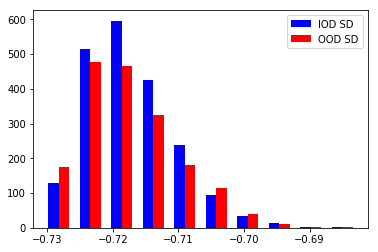

In [16]:
sd_test_IOD_df = pd.DataFrame(sd_test_IOD)
sd_test_OOD_df = pd.DataFrame(sd_test_OOD)
new_scores = np.concatenate([sd_test_IOD_df[0], sd_test_OOD_df[0]], axis=0)
new_labels = np.concatenate([np.zeros_like(sd_test_IOD_df[0]), np.ones_like(sd_test_OOD_df[0])], axis=0)
histogram_df = pd.DataFrame(new_scores, new_labels)
print(new_scores.max())
print(new_scores.min())
#histogram_df.hist(column=0)

#sd_test_IOD_df.hist(column=0)
#sd_test_OOD_df.hist(column=0)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

a_heights, a_bins = np.histogram(sd_test_IOD_df[0])
b_heights, b_bins = np.histogram(sd_test_OOD_df[0], bins=a_bins)

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width = width, facecolor='blue',label="IOD SD")
ax.bar(b_bins[:-1]+width, b_heights, width = width, facecolor='red', label="OOD SD")
ax.legend()


0.5176189210679796


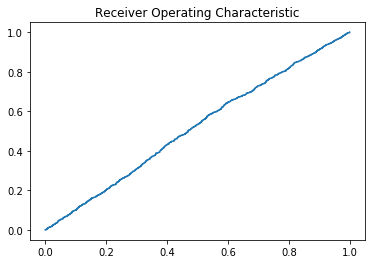

In [15]:
from sklearn.metrics import roc_curve, roc_auc_score

norm_scores = new_scores - min(new_scores) / (max(new_scores) - min(new_scores))

auc = roc_auc_score(new_labels, new_scores)
fpr, tpr, threshs = roc_curve(new_labels, norm_scores, drop_intermediate=True)
print(auc)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr)
plt.show()
